# Методы оптимизации
## Лабораторная работа № 2
### Методы минимизации функций многих переменных

In [1]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (14, 14)

In [3]:
funcs = [(lambda x: x**3 - 3*np.sin(x),[0,1]),
            (lambda x: x**4 + x**2 + x + 1,[-1,0]),
            (lambda x: np.exp(x) + 1/x,[-1,-10**-8]),
            (lambda x: x**2 - 2*x + np.exp(-x),[-1,1.5]),
            (lambda x: x*np.sin(x) + 2*np.cos(x),[-6,-4]),
            (lambda x: x + 1/(x**2),[1,2]),
            (lambda x: 10*x*np.log(x) - (x**2)/2,[0.1,1]),
            (lambda x: np.exp(x) - (x**3)/3 + 2*x,[-2.5,-1]),
            (lambda x: x**2 - 2*x - 2*np.cos(x),[-0.5,1]),]

def select_function(n):
    return funcs[n-1]

In [33]:
# для тестирования методов
def test_func(func,args=None,n=4,eps=10**-5,title=None,f=None):
    plt.figure()
    if title:
        plt.title(title)
    sns.set_context("poster")
    if f:
        f,bounds = f
    else:
        f,bounds = select_function(n)
    x = np.linspace(bounds[0],bounds[1],1000)
    
    plt.plot(x,f(x))
    plt.xlabel('x')
    plt.ylabel('y')
    
    if args:
        x,y,n = func(f,bounds,eps=eps,**args)
    else:
        x,y,n = func(f,bounds,eps=eps)
    plt.scatter(x,y,color='red')
    print(int(x/eps)*eps,int(y/eps)*eps,n)


#### Рисование графиков

In [5]:
"""
Illustrate simple contour plotting, contours on an image with
a colorbar for the contours, and labelled contours.

See also contour_image.py.
"""
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def plot_countor(f,a,b,flag=False,h=0.01):
    #sns.set_context("poster")
    x = np.arange(a, b, h)
    y = np.arange(a, b, h)
    X, Y = np.meshgrid(x, y)

    Z = f(X,Y)

    # Or you can use a colormap to specify the colors; the default
    # colormap will be used for the contour lines
    plt.figure()
    plt.grid(False)
    contours = plt.contourf(X, Y, Z, 20, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(Z, extent=[0, 5, 0, 5], origin='lower',
               cmap='RdGy', alpha=0.5)
    '''
    plt.imshow(Z, extent=[a, b, a, b], origin='lower',
           cmap='RdGy')'''
    CB = plt.colorbar()
    plt.axis(aspect='image');
    # make a colorbar for the contour lines
    if flag:
        plt.flag()
    l, b, w, h = plt.gca().get_position().bounds
    ll, bb, ww, hh = CB.ax.get_position().bounds
    CB.ax.set_position([ll, bb+0.1255, ww, 0.5])
    

    plt.show()

In [6]:
def plot_countor2(f,a1,b1,a2,b2,flag=False,h=0.01):
    sns.set_context("talk")
    sns.set_style('whitegrid')
    xlist = np.linspace(a1, b1, 300)
    ylist = np.linspace(a2, b2, 300)
    X, Y = np.meshgrid(xlist, ylist)
    Z = f(X,Y)
    cp = plt.contour(X, Y, Z, 40,colors='black');
    plt.clabel(cp, inline=True, fontsize=16)
    #plt.colorbar(cp)
    plt.xlabel('x')
    plt.ylabel('y')

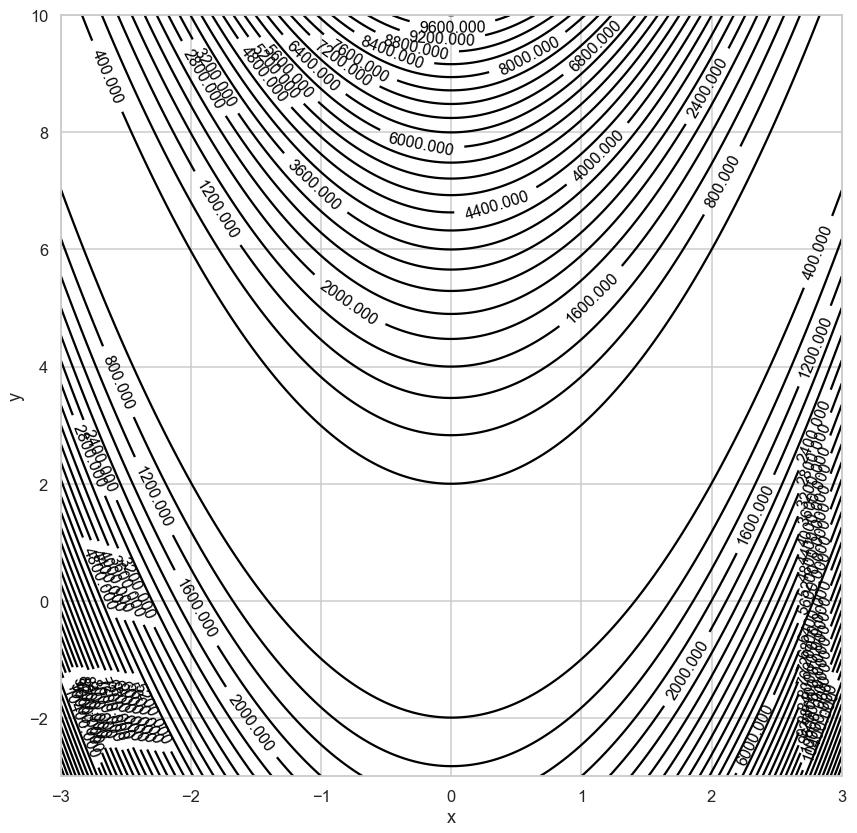

In [7]:
f5 = lambda x1,x2: 100*((x1**2-x2)**2)+(x1-1)**2
fun = lambda x1,x2:f5(x1,x2)
plot_countor2(fun,-3,3,-3,10)

#### Метод поразрядного поиска

In [8]:
def iteration_striking_search(f,x,delta,f1,n=1):
    x += delta
    f2 = f(x)
    n += 1
    
    while f2 < f1:
        f1 = f2
        x += delta
        f2 = f(x)
        n += 1
        
    return x,f2,n
    

def striking_search(f,bounds,delta=1/4,eps=0.001,eta=4,verbose=False):
    a,b=bounds
    
    eta = -1*np.abs(eta)
    
    x = a
    f2 = f(x)
    n = 1
    old_x = x
    old_f = f2
    
    while not np.abs(delta*eta) < eps:    
        x,f2,n = iteration_striking_search(f,x,delta,f2,n)
        
        if verbose:
            plt.plot([old_x,x],[old_f,f2])
            old_x = x
            old_f = f2
        
        delta /= eta
    
    return x-delta*eta,f2,n


In [9]:
# центральная
def cf(f,x,h=0.001):
    return (f(x+h)-f(x-h))/(2*h)

# вторая
def cff(f,x,h=0.001):
    return (f(x+h)-2*f(x)+f(x-h))/(h**2)

# левая
def lf(f,x,h=0.001):
    return (f(x)-f(x-h))/h

# правая
def rf(f,x,h=0.001):
    return (f(x+h)-f(x))/h

# вторая (x,y)
def cffxy(f,x,y,h=0.001):
    a = f(x+h,y+h)-f(x,y)
    b = cf(lambda z:f(z,y),x,h) + cf(lambda z:f(x,z),y,h)
    c = cff(lambda z:f(z,y),x,h) + cff(lambda z:f(x,z),y,h)
    return a/h/h - b/h - c/2

In [10]:
def create_func_for_gradient(fun,x,i):
    if i >= len(x) or i < 0:
        return 0
    
    temp_x = copy(x)
    def f(z):
        temp_x[i] = z
        return fun(*temp_x)
   
    return (lambda z:f(z))
    
def gradient(f,x):
    res = np.zeros(len(x))
    
    for i in range(len(x)):
        temp_f = create_func_for_gradient(f,x,i)
        res[i] = cf(temp_f,x[i])
    
    return res,len(x)

In [11]:
def create_func_for_hesse(fun,x,i,j):
    if i >= len(x) or i < 0:
        return 0
    
    temp_x = copy(x)
    def f(z1,z2):
        temp_x[i] = z1
        temp_x[j] = z2
        return fun(*temp_x)
   
    return (lambda z1,z2:f(z1,z2))
    
def hesse(f,x):
    res = np.zeros([len(x),len(x)])
    
    for i in range(len(x)):
        for j in range(len(x)):
            if i == j:
                temp_f = create_func_for_gradient(f,x,i)
                res[i][j] = cff(temp_f,x[i])
            else:
                temp_f = create_func_for_hesse(f,x,i,j)
                res[i][j] = cffxy(temp_f,x[i],x[j])

    return res,len(x)*len(x)

In [12]:
def euklid(f):
    return np.sqrt(np.sum(f**2))

In [13]:
def test_func_multi(f,*args,**kargs):
    #return f(lambda x,y:x**2+1000*(y**2),*args,**kargs) 
    
    return f(lambda x1,x2: 151*x1*x1 - 300*x1*x2 + 151*x2*x2 + 33* x1 + 99*x2 + 48,*args,**kargs)

#### Метод наискорейшего спуска

(array([-32.94485613, -33.05448988]), -2131.808969885744, 902, 1805)

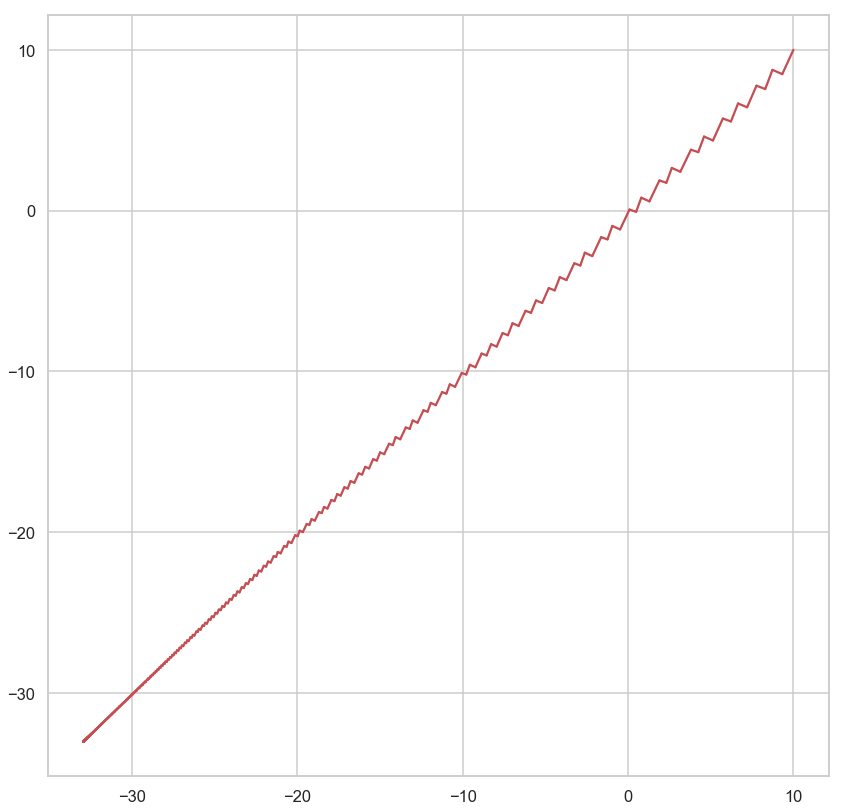

In [54]:
def fast_descent(f,x0,eps=10**-3,norm=euklid,verbose=False):
    
    n = len(inspect.getfullargspec(f).args)

    
    #x = np.random.random([n])
    x = np.array(x0)
    y = f(*x)
    
    g,n_s = gradient(f,x)
    
    it = 1
    n_f = n_s+1
    flag = False
    
    if verbose:
        #plot_countor2(f,-40,20,-40,20)
        pass
        
    while not norm(g) < eps:
        
        alpha,_,n_s = striking_search(lambda a: f(*(x-a*g)),x0,eps=eps)
        
        #alpha = minimize(lambda a: f(*(x-a*g)),[1,1],tol=eps/10).x
        #n_f += n_s
        
        #print(alpha,norm(g))
        if alpha < eps:
            if flag:
                break
            else:
                flag = True
        x_old = x
        x = x - alpha*g
        
        if verbose:
            X = [x_old[0],x[0]]
            Y = [x_old[1],x[1]]
            #plt.arrow(x_old[0],x_old[1],x[0]-x_old[0],x[1]-x_old[1],color='r',label='Наиск. спуск')
            plt.plot([x_old[0],x[0]],[x_old[1],x[1]],color='r',label='Наиск. спуск')
            #plt.plot(X,Y,color='r')
            #plt.scatter(X,Y,color='g')
        g,n_s = gradient(f,x)
        n_f += n_s
        
        it += 1
        
        
    return x,f(*x),it,n_f
    

test_func_multi(fast_descent,[10,10],verbose=True)  

#### Метод сопряженных градиентов

(array([-32.94485192, -33.05448584]), -2131.8089698803697, 945, 1890)

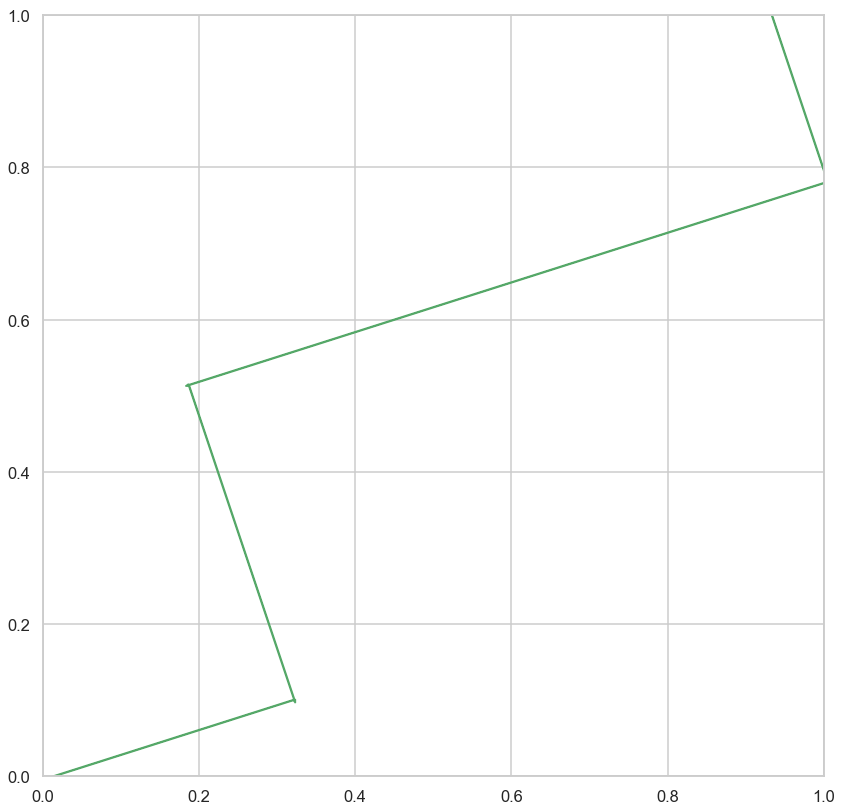

In [40]:
def sopr_grad(f,x0,eps=10**-3,norm=euklid,n=1,verbose=False):
    
    beta = 0
    
    x = x0
    g0,n_s = gradient(f,x)
    
    k = 0
    p = -g0
    
    it = 1
    n_f = n_s
    flag = False
    while not norm(g0) < eps:
        
        alpha,_,n_s = striking_search(lambda z:f(*(x+z*p)),[1,1],eps=1e-10)
        
        #alpha = minimize(lambda a: f(*(x+a*p)),[1,1],tol=eps/10).x
        #n_f += n_s
        if alpha == 0:
            if flag:
                break
            else:
                flag = True
        x = x + alpha*p
        g1,n_s = gradient(f,x)
        n_f += n_s
        
        if k+1 == n:
            beta = 0
        else:
            k += 1
            beta = norm(g1)**2/(norm(g0)**2)
        
        if verbose:
            x_old = x-alpha*p
            X = [x_old[0],x[0]]
            Y = [x_old[1],x[1]]
            plt.arrow(x_old[0],x_old[1],x[0]-x_old[0],x[1]-x_old[1],color='g',label='Сопр. град')
            #plt.plot(X,Y,color='r')
            #plt.scatter(X,Y,color='g')
        
        p = -g1 + beta*p
        g0 = g1
        
        
        it += 1
           

    return x,f(*x),it,n_f

test_func_multi(sopr_grad,[10,10],verbose=True)  

#### Метод Ньютона

(array([-32.94520483, -33.05483939]), -2131.80897009865, 3, 14)

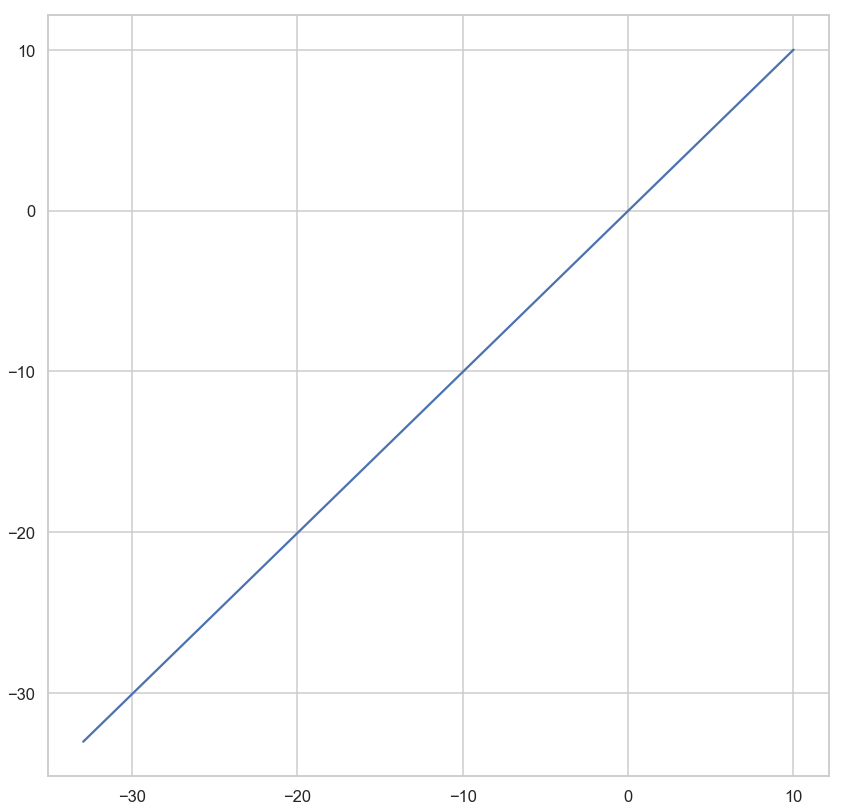

In [58]:
def newton(f,x0,eps=10**-3,norm=euklid,verbose=False):
    
    x = x0
    g,n_s = gradient(f,x)
    
    n_f = n_s
    it = 1
    
    while not norm(g) < eps:
        hs,n_s = hesse(f,x)
        n_f += n_s
        
        d = np.linalg.inv(hs).dot(g)
        x -= d
        g,n_s = gradient(f,x)
        n_f += n_s
        
        it += 1
        if verbose:
            x_old = x+d
            X = [x_old[0],x[0]]
            Y = [x_old[1],x[1]]
            #plt.arrow(x_old[0],x_old[1],x[0]-x_old[0],x[1]-x_old[1],color='b',label='Ньютон')
            plt.plot(X,Y,color='b',label='Ньютон')
            #plt.plot(X,Y,color='r')
            #plt.scatter(X,Y,color='g')
            
        
    return x,f(*x),it,n_f


test_func_multi(newton,[10,10],verbose=True)  

#### Метод правильного симплекса

(array([-32.86974696, -32.97912754]), -2131.797540932709, 2231, 2377)

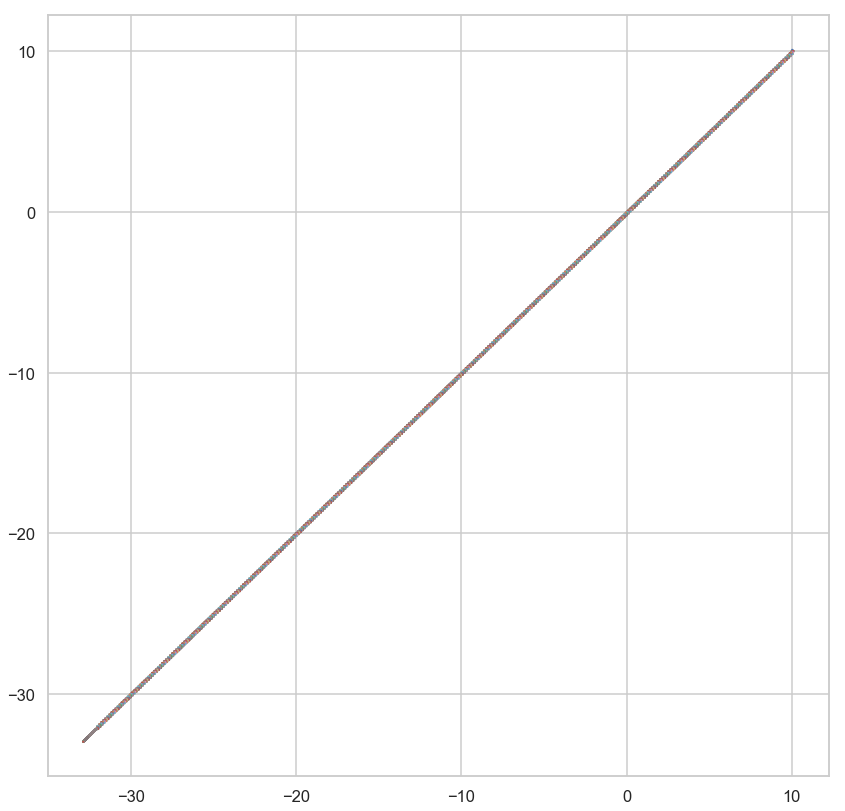

In [96]:
def right_simplex(f,x0,l=1/10,eps=1e-3,norm=euklid,verbose=False):
    n = len(x0)
    k2 = 4
    S = [np.array(x0)]
    
    for i in range(1,n+1):
        temp = np.zeros(n)
        for j in range(n):
            if i == j+1:
                temp[j] = x0[j] + (np.sqrt(n+1) - 1)*l/n/np.sqrt(2)
            else:
                temp[j] = x0[j] + (np.sqrt(n+1) + n - 1)*l/n/np.sqrt(2)
        S.append(temp)
    
    y_S = [f(*x) for x in S]
    
    it = 0
    n_f = len(S)
    
    if verbose:
        
        #plot_countor2(f,-40,20,-40,20)
        plt.plot(np.array(S)[:,0],np.array(S)[:,1],label='Симплекс')
        plt.plot(np.array([S[0],S[-1]])[:,0],np.array([S[0],S[-1]])[:,1])
    
    temp = copy(y_S)
    temp_ind = [i for i in range(0,len(y_S))]
    
    condition = l
    S_old = copy(S)
    
    while not condition < eps:
        
        for k in range(n):
            ind_max = temp_ind[np.argmax(temp)]
            x_max,y_max = S[ind_max],y_S[ind_max]

            sm = np.zeros(n)
            for i in range(n+1):
                if i != ind_max:
                    sm += S[i]
                    
            x_new = 2*sm/n-x_max
            y_new = f(*x_new)
            
            n_f += 1

            
            if y_new < y_max:
                S[ind_max] = x_new
                y_S[ind_max] = y_new
                temp = copy(y_S)
                temp_ind = [i for i in range(0,len(y_S))]
                
                #condition = norm(np.array(S[0])-np.array(S[1]))
                S_old = copy(S)
                
                if verbose:
                    plt.plot(np.array(S)[:,0],np.array(S)[:,1])
                    plt.plot(np.array([S[0],S[-1]])[:,0],np.array([S[0],S[-1]])[:,1])

                break

            elif k == n-1:
                ind_min = np.argmin(y_S)
                for i in range(n+1):
                    if i == ind_min:
                        continue
                    S[i] = S[ind_min] + (S[i] - S[ind_min])/k2

                #condition = norm(np.array(S[0])-np.array(S[1]))
                condition /= k2
                S_old = copy(S)
                
                y_S = [f(*x) for x in S]
                n_f += len(S)

                temp = copy(y_S)
                temp_ind = [i for i in range(0,len(y_S))]
                
                if verbose:
                    plt.plot(np.array(S)[:,0],np.array(S)[:,1])
                    plt.plot(np.array([S[0],S[-1]])[:,0],np.array([S[0],S[-1]])[:,1])
                
                break
            else:
                temp = [temp[i] for i in range(len(temp)) if i != ind_max]
                temp_ind = [temp_ind[i] for i in range(len(temp_ind)) if i != ind_max]
                
        it += 1
   
    ind_min = np.argmin(y_S)
    
    return S[ind_min],y_S[ind_min],it,n_f
        
test_func_multi(right_simplex,[10,10],verbose=True)  

#### Метод циклического покоординатного спуска

(array([-32.99511719, -33.10490521]), -2131.803964315136, 369, 738)

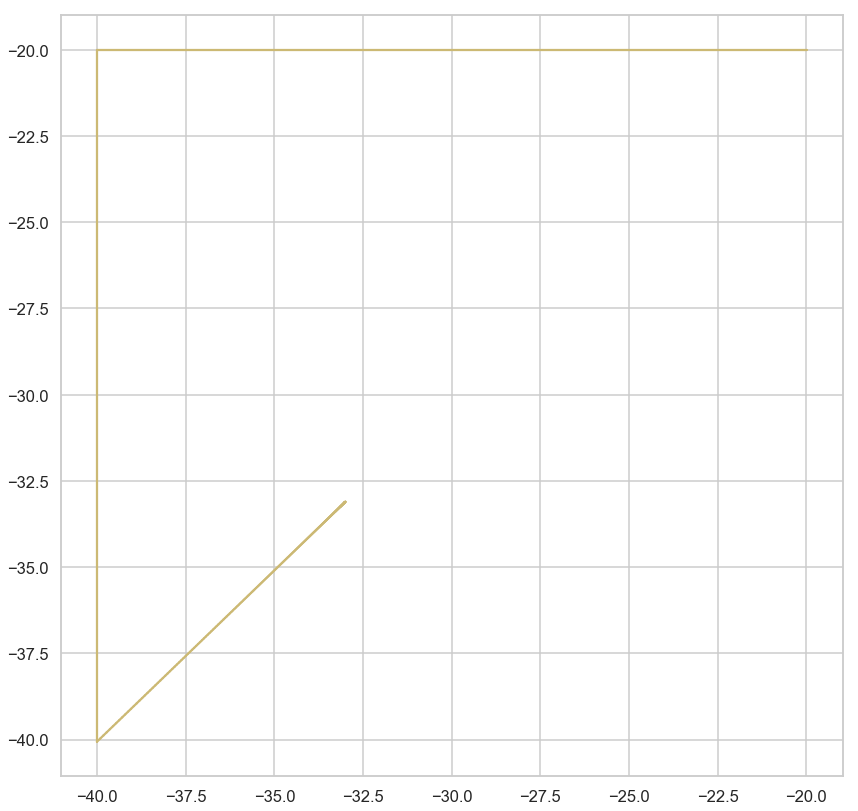

In [61]:
def circle_descent(f,x0,eps=1e-3,verbose=False):
    
    if verbose:
        #plot_countor2(f,-70,0,-70,0)
        pass
    #eps1 = eps
    #eps2 = eps
    n = len(x0)
    x_old = x0
    
    it = 1
    n_f = 2
    
    for j in range(n):
            e = np.zeros(n)
            e[j] = 1
            #alpha,_,n_s = striking_search(lambda a:f(*(x_old+a*e)),[0,0],eps=eps/10)
            alpha = minimize(lambda a:f(*(x_old+a*e)),[1,1],tol=eps).x
            #n_f += n_s
            
            x_new = x_old + alpha*e
            if verbose:
                X = [x_old[0],x_new[0]]
                Y = [x_old[1],x_new[1]]
                
                plt.plot(X,Y,color='y')
                #plt.scatter(X,Y,color='g')
        
    while not (norm(x_old-x_new)<eps):# and (np.abs(f(*x_new)-f(*x_old))<eps)):
        
        x_old = copy(x_new)
        
        for j in range(n):
            e = np.zeros(n)
            e[j] = 1
            alpha,_,n_s = striking_search(lambda a:f(*(x_new+a*e)),[0,0],eps=eps)
            #alpha = minimize(lambda a:f(*(x_new+a*e)),[1,1],tol=eps).x
            #n_f += n_s
            
            x_new = x_new + alpha*e
            
        if verbose:
            X = [x_old[0],x_new[0]]
            Y = [x_old[1],x_new[1]]

            plt.plot(X,Y,color='y',label='Циклич. спуск')
            #plt.scatter(X,Y,color='g')
            
        it += 1
        n_f += 2
        
        
    return x_new,f(*x_new),it,n_f


test_func_multi(circle_descent,[-40,-20],verbose=True)

#### Метод Хука-Дживса

(array([-32.9335022 , -33.04336548]), -2131.808694673702, 1679, 6685)

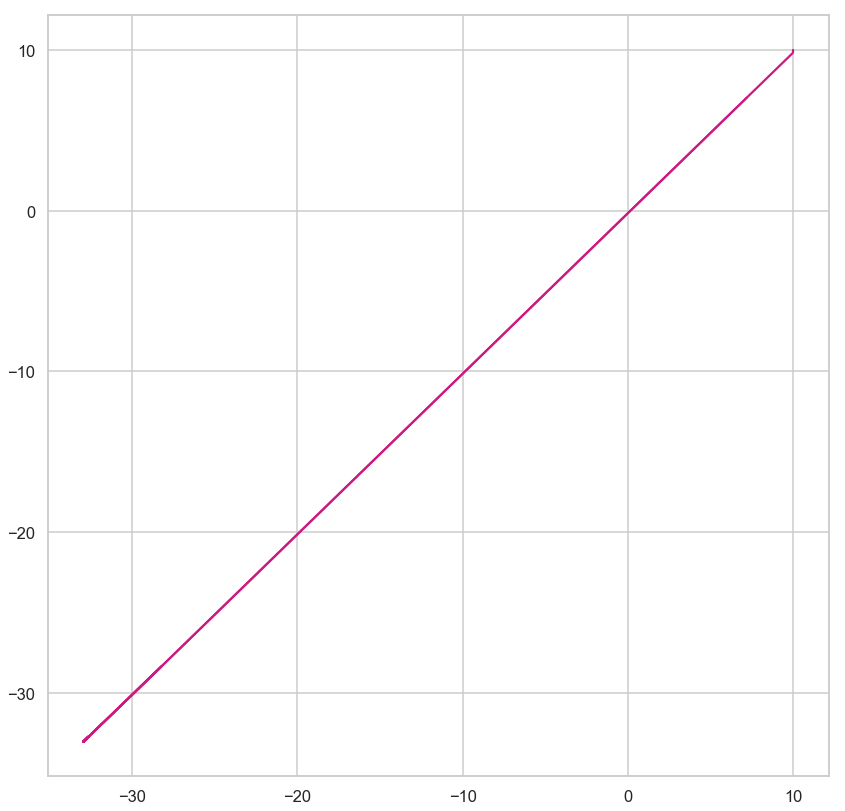

In [57]:
def pokoord_search(f,x0,d):

    n = len(x0)
    x = copy(x0)
    
    it = 0
    n_f = 0    

    for j in range(n):
        e = np.zeros(n)
        e[j] = 1
        
        y1 = x - d*e
        y2 = x + d*e
        
        f1 = f(*x)
        n_f += 1
        
        if f1 > f(*y1):
            x = y1
            n_f += 1

        elif f1 > f(*y2):
            x = y2
            n_f += 1
            
    return x,f(*x),n_f
                

def hook_djivs(f,x0,gamma=4,eps=1e-3,norm=euklid,verbose=False):
    
    n = len(x0)
    d = np.array(x0)#np.random.random(n)
    
    x_old = np.array(x0)
    
    it = 0
    n_f = 0
    
    while not norm(d*gamma) < eps :
        x_new,_,n_s = pokoord_search(f,x_old,d)
                        
        n_f += n_s
        
        if (n_s == n):
            d = d / gamma
        else:
            x_old = x_old + (x_new-x_old)/gamma
            
        it += 1
        if verbose:
            x_o = x_old - (x_new-x_old)/gamma
            x_n = x_old
            X = [x_o[0],x_n[0]]
            Y = [x_o[1],x_n[1]]
            #plt.arrow(x_o[0],x_o[1],x_n[0]-x_o[0],x_n[1]-x_o[1],color=(0.8,0.1,0.5),label='Хука-Дживса')
            plt.plot(X,Y,color=(0.8,0.1,0.5),label='Хука-Дживса')
            #plt.plot(X,Y,color='r')
            #plt.scatter(X,Y,color='g')
        
    return x_old,f(*x_old),it,n_f
    
test_func_multi(hook_djivs,[10,10],verbose=True)  

#### Метод случайного поиска

(array([-32.94453793, -33.05415024]), -2131.8089691647124, 11, 1193)

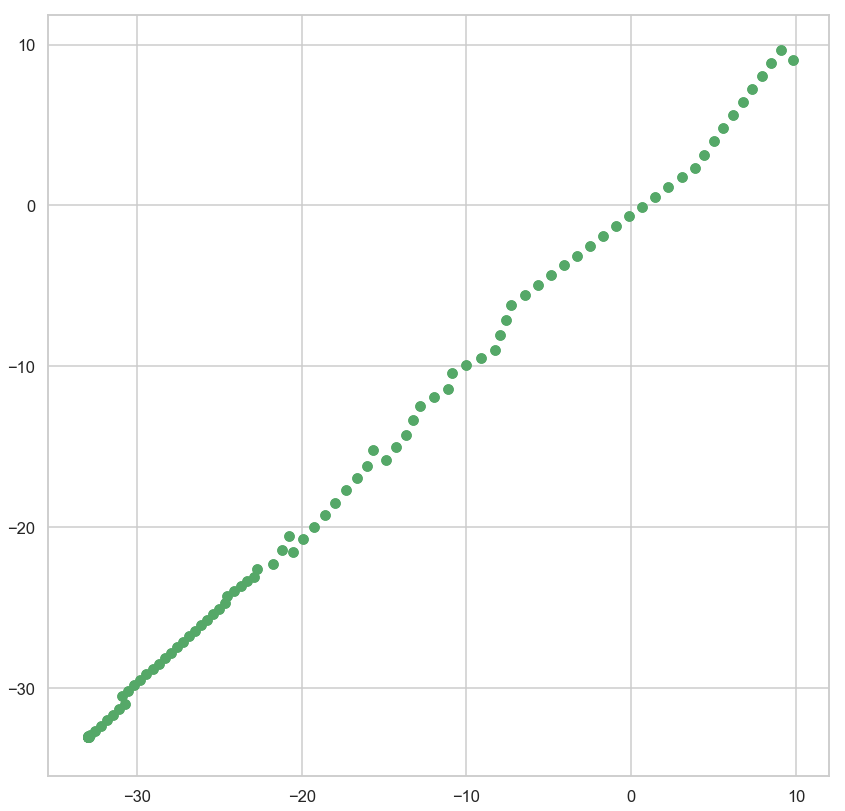

In [46]:
def random_search(f,x0,alpha=1,gamma=2,M=100,eps=10**-3,norm=euklid,verbose=False):

    n = len(x0)
    x_old = copy(x0)
    y_old = f(*x_old)
    
    it = 0
    n_f = 1
    
    while not (alpha*gamma) < eps:
        
        for j in range(M):
            e = np.random.rand(n)*2-1
            
            while True:
                x_new = x_old + alpha*e/norm(e)
                y_new = f(*x_new)
                n_f +=1
                
                if y_new < y_old:
                    x_old = x_new
                    y_old = y_new
                else:
                    break
                    
                if verbose:
                    x_o = x_old
                    x_n = x_new
                    X = [x_o[0],x_n[0]]
                    Y = [x_o[1],x_n[1]]
                    #plt.arrow(x_o[0],x_o[1],x_n[0]-x_o[0],x_n[1]-x_o[1],color='r')
                    #plt.plot(X,Y,color='r')
                    plt.scatter(X,Y,color='g',label='Случайный поиск')
        
        alpha = alpha/gamma
        
        it += 1
        
    return x_old,f(*x_old),it,n_f
            
            
        
test_func_multi(random_search,[10,10],verbose=True)  
    

### Задание №2

In [21]:
def test_func_multi2(f,f1,*args,**kargs):

    return f(f1,*args,**kargs) 

1
М. наискорейшего спуска 0.1 0.01 0.001 0.0001 1e-05 
М. сопряженных градиентов 0.1 0.01 0.001 0.0001 1e-05 
М. Ньютона 0.1 0.01 0.001 0.0001 1e-05 
М. правильного симплекса 0.1 0.01 0.001 0.0001 1e-05 
М. циклического спуска 0.1 0.01 0.001 0.0001 1e-05 
М. Хука-Дживса 0.1 0.01 0.001 0.0001 1e-05 
М. случайного поиска 0.1 0.01 0.001 0.0001 1e-05 
250
М. наискорейшего спуска 0.1 0.01 0.001 0.0001 1e-05 
М. сопряженных градиентов 0.1 0.01 0.001 0.0001 1e-05 
М. Ньютона 0.1 0.01 0.001 0.0001 1e-05 
М. правильного симплекса 0.1 0.01 0.001 0.0001 1e-05 
М. циклического спуска 0.1 0.01 0.001 0.0001 1e-05 
М. Хука-Дживса 0.1 0.01 0.001 0.0001 1e-05 
М. случайного поиска 0.1 0.01 0.001 0.0001 1e-05 
1000
М. наискорейшего спуска 0.1 0.01 0.001 0.0001 1e-05 
М. сопряженных градиентов 0.1 0.01 0.001 0.0001 1e-05 
М. Ньютона 0.1 0.01 0.001 0.0001 1e-05 
М. правильного симплекса 0.1 0.01 0.001 0.0001 1e-05 
М. циклического спуска 0.1 0.01 0.001 0.0001 1e-05 
М. Хука-Дживса 0.1 0.01 0.001 0.0001 1e

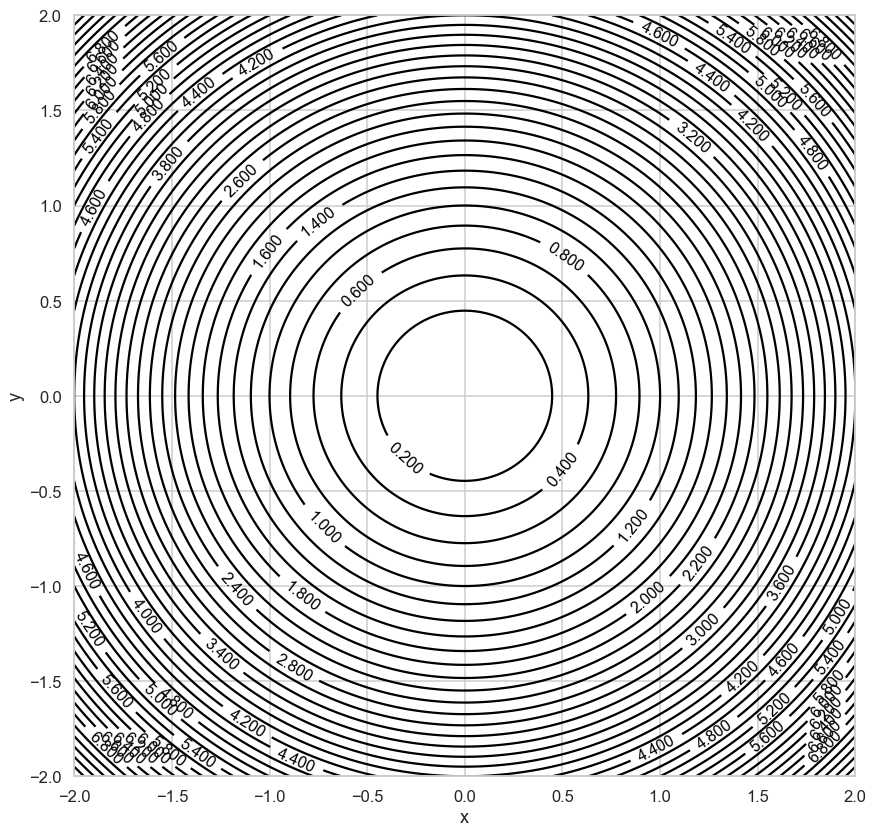

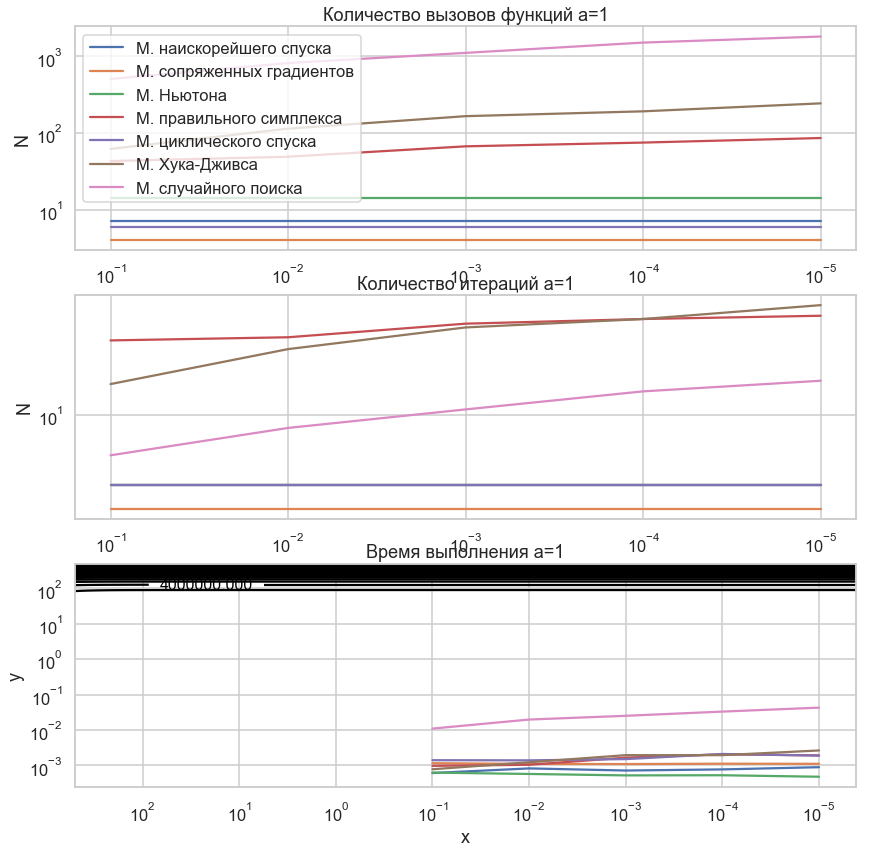

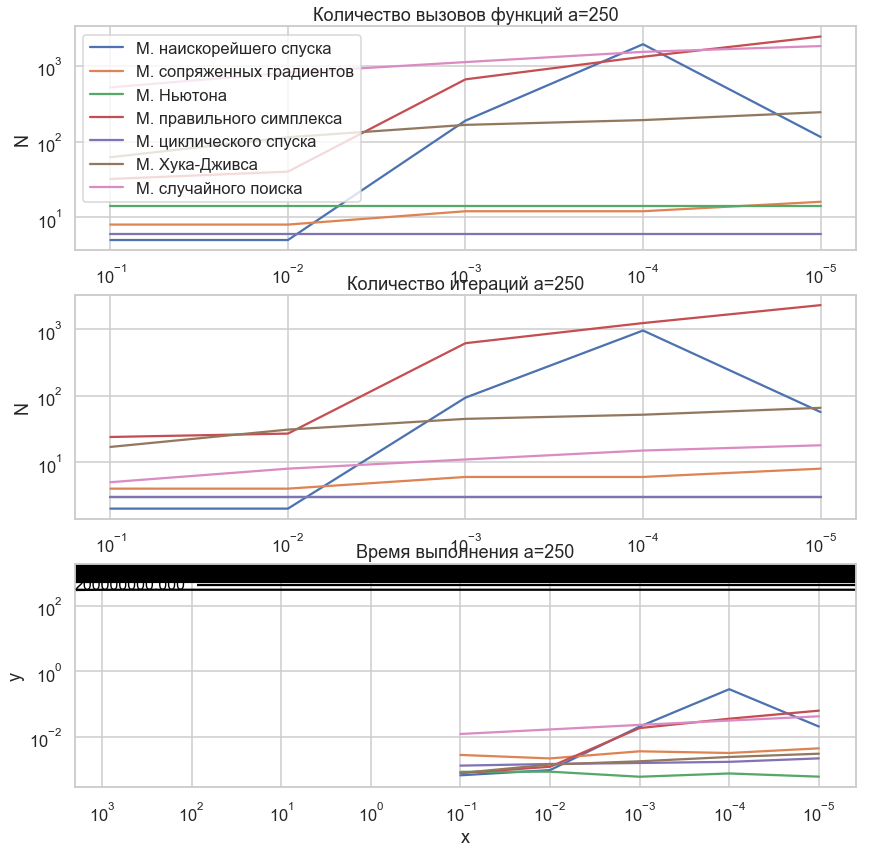

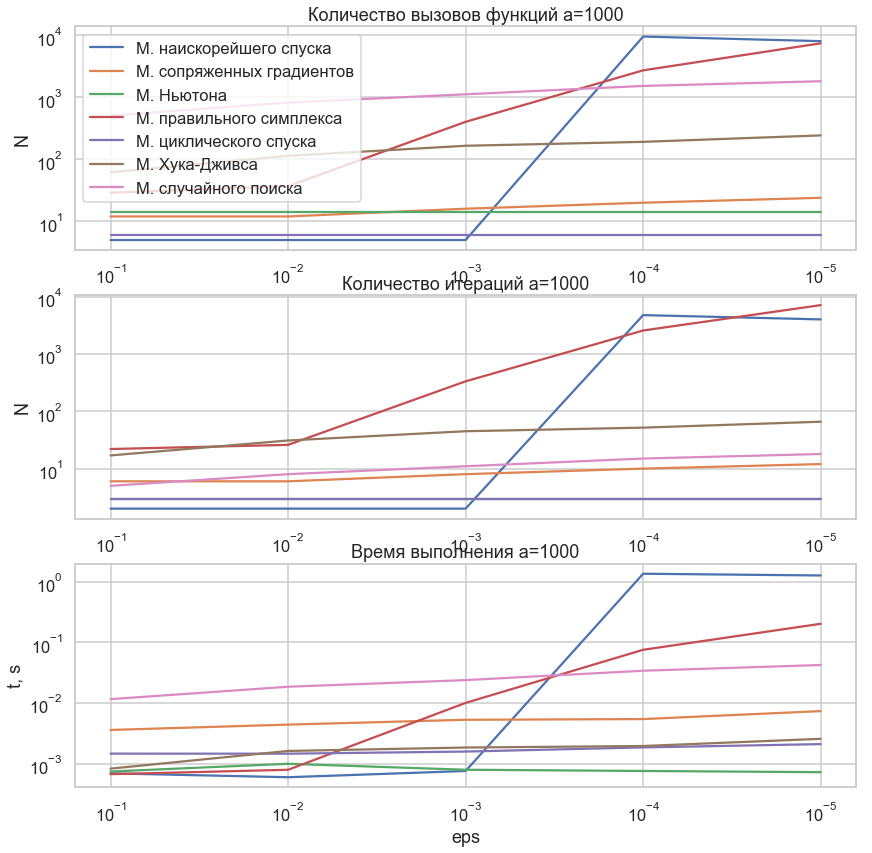

In [22]:
%%time
import time
sns.set_context("talk")

f = lambda x1,x2,a: x1**2 + a*(x2**2)


a,b = 1,1
methods = [
    ('М. наискорейшего спуска',fast_descent,[a,b]),
    ('М. сопряженных градиентов',sopr_grad,[a,b]),
    ('М. Ньютона',newton,[a,b]),
    ('М. правильного симплекса',right_simplex,[a,b]),
    ('М. циклического спуска',circle_descent,[a,b]),
    ('М. Хука-Дживса',hook_djivs,[a,b]),
    ('М. случайного поиска',random_search,[a,b]),
]


a = [1, 250, 1000]
eps = [10**-i for i in range(1,6)]

size_subplots = [3,1]

for ai in a:
    plot_countor2(lambda x1,x2:f(x1,x2,ai),-2*ai,2*ai,-2*ai,2*ai,h=ai/1000)
    print(ai)
    
    plt.figure()
    
    current_f = lambda x1,x2: f(x1,x2,ai)
    
    
    for (label,method,bound) in methods:
        print(label,end=' ')
        n_f = []
        it = []
        times = []
        for ei in eps:
            print(ei,end=' ')
            arg = [method,current_f]
            if bound != None:
               arg.append(bound) 
            
            start = time.clock()
            x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei)
            stop = time.clock()
            
            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)
            
        print(end='\n')
        
        plt.subplot(size_subplots[0],size_subplots[1],1)
        plt.plot(eps,n_f,label=label)
        plt.xscale('log')
        
        plt.subplot(size_subplots[0],size_subplots[1],2)
        plt.plot(eps,it,label=label)
        plt.xscale('log')
        
        plt.subplot(size_subplots[0],size_subplots[1],3)
        plt.plot(eps,times,label=label)
        plt.xscale('log')
    
    plt.subplot(size_subplots[0],size_subplots[1],1)
    plt.title('Количество вызовов функций а='+str(ai))
    plt.legend(loc='upper left')
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')
    
    
    plt.subplot(size_subplots[0],size_subplots[1],2)
    plt.title('Количество итераций а='+str(ai))
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')
        
    plt.subplot(size_subplots[0],size_subplots[1],3)
    plt.title('Время выполнения а='+str(ai))
    plt.gca().invert_xaxis()
    plt.xlabel('eps')
    plt.ylabel('t, s')
    plt.yscale('log')
        

### Задание №3

М. наискорейшего спуска 0.1 0.01 0.001 0.0001 
М. сопряженных градиентов 0.1 0.01 0.001 0.0001 
М. Ньютона 0.1 0.01 0.001 0.0001 
М. правильного симплекса 0.1 0.01 0.001 0.0001 
М. циклического спуска 0.1 0.01 0.001 0.0001 
М. Хука-Дживса 0.1 0.01 0.001 0.0001 
М. случайного поиска 0.1 0.01 0.001 0.0001 
Wall time: 3.74 s


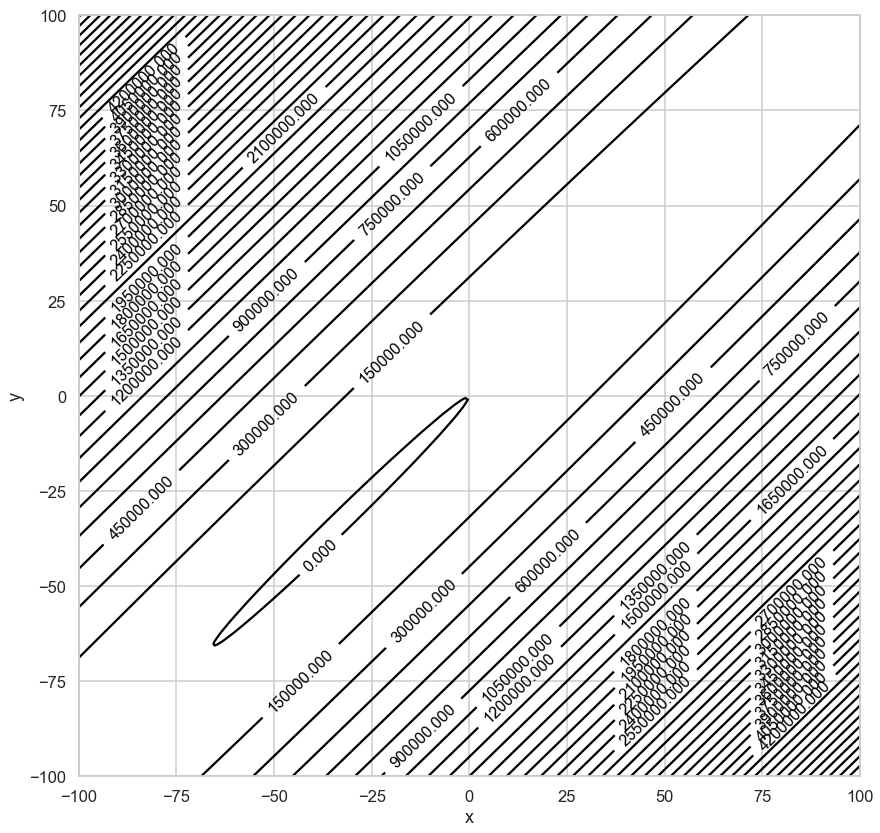

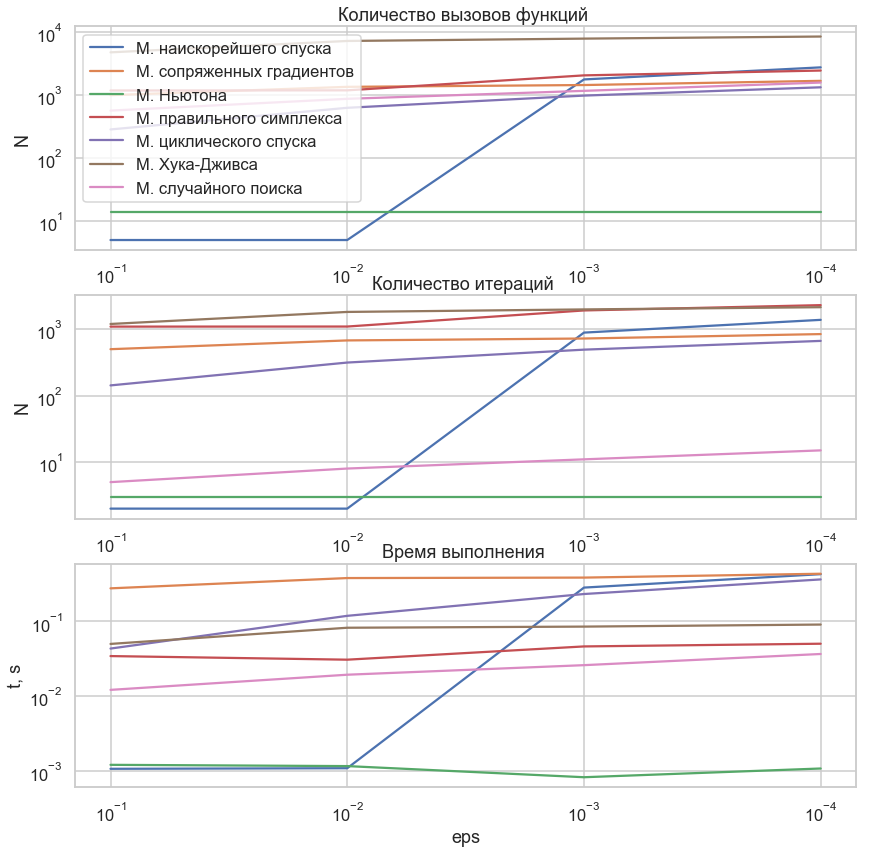

In [23]:
%%time
import time
sns.set_context("talk")

f4 = lambda x1,x2: 151*x1*x1 - 300*x1*x2 + 151*x2*x2 + 33* x1 + 99*x2 + 48

plot_countor2(f4,-100,100,-100,100,h=200/1000)
a,b = 1,1
methods = [
    ('М. наискорейшего спуска',fast_descent,[a,b]),
    ('М. сопряженных градиентов',sopr_grad,[a,b]),
    ('М. Ньютона',newton,[a,b]),
    ('М. правильного симплекса',right_simplex,[a,b]),
    ('М. циклического спуска',circle_descent,[a,b]),
    ('М. Хука-Дживса',hook_djivs,[a,b]),
    ('М. случайного поиска',random_search,[a,b]),
]


eps = [10**-i for i in range(1,5)]
#eps = [10**-3,10**-5]

size_subplots = [3,1]

   
plt.figure()
current_f = f4

for (label,method,bound) in methods:
    print(label,end=' ')
    n_f = []
    it = []
    times = []
    for ei in eps:
        print(ei,end=' ')
        arg = [method,current_f]
        if bound != None:
           arg.append(bound) 

        start = time.clock()
        x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei)
        stop = time.clock()

        n_f.append(n_s)
        it.append(it_s)
        times.append(stop-start)

    print(end='\n')

    plt.subplot(size_subplots[0],size_subplots[1],1)
    plt.plot(eps,n_f,label=label)
    plt.xscale('log')

    plt.subplot(size_subplots[0],size_subplots[1],2)
    plt.plot(eps,it,label=label)
    plt.xscale('log')

    plt.subplot(size_subplots[0],size_subplots[1],3)
    plt.plot(eps,times,label=label)
    plt.xscale('log')

plt.subplot(size_subplots[0],size_subplots[1],1)
plt.title('Количество вызовов функций ')
plt.legend(loc='upper left')
plt.gca().invert_xaxis()
plt.ylabel('N')
plt.yscale('log')


plt.subplot(size_subplots[0],size_subplots[1],2)
plt.title('Количество итераций ')
plt.gca().invert_xaxis()
plt.ylabel('N')
plt.yscale('log')

plt.subplot(size_subplots[0],size_subplots[1],3)
plt.title('Время выполнения ')
plt.gca().invert_xaxis()
plt.xlabel('eps')
plt.ylabel('t, s')
plt.yscale('log')
        

### Задание №5

М. наискорейшего спуска 0.001 0.0001 
М. Ньютона 0.001 0.0001 
М. правильного симплекса 0.001 0.0001 
М. циклического спуска 0.001 0.0001 
М. Хука-Дживса 0.001 0.0001 
М. случайного поиска 0.001 0.0001 

Wall time: 1.41 s


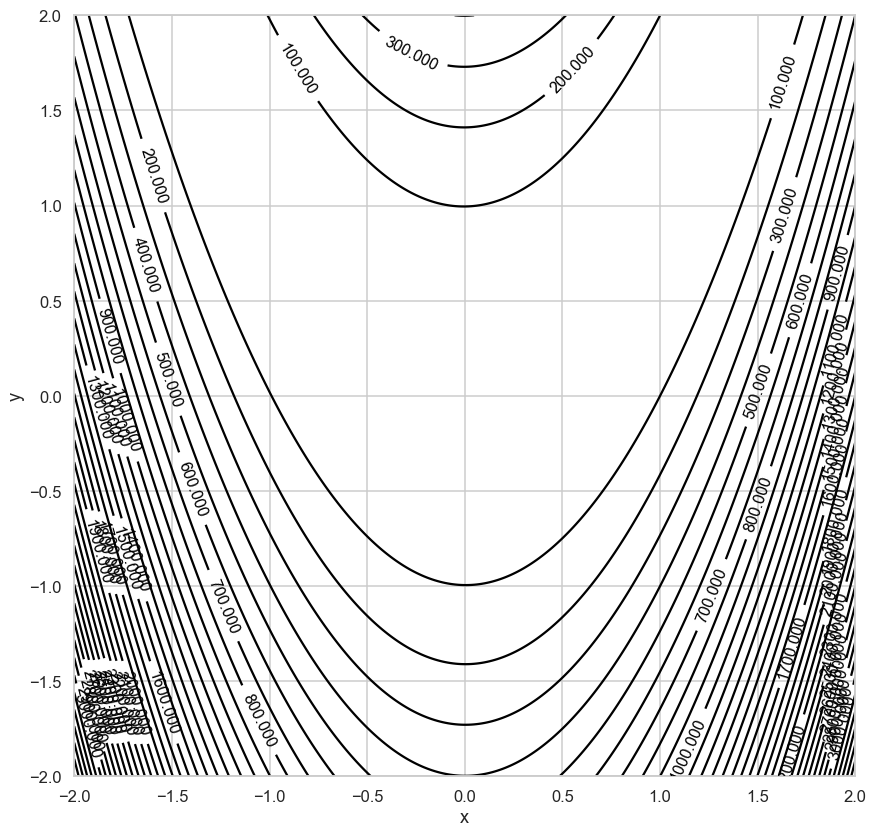

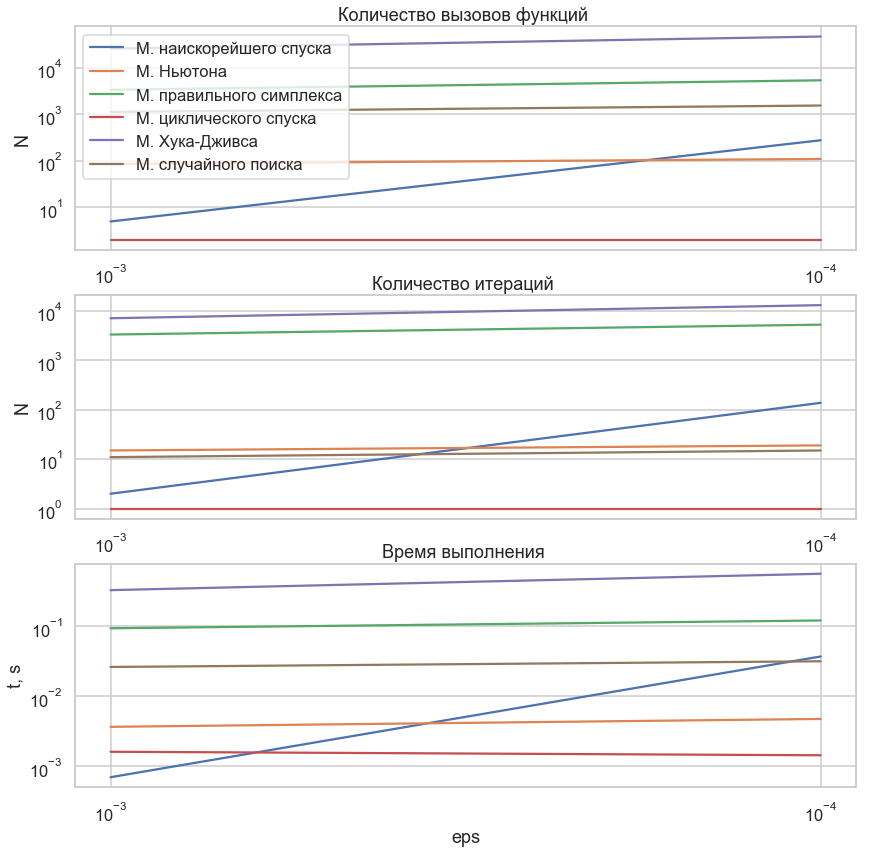

In [24]:
%%time
from scipy.optimize import minimize
import time
sns.set_context("talk")


f5 = lambda x1,x2: 100*((x1**2-x2)**2)+(x1-1)**2


a,b = -1,1
methods = [
    ('М. наискорейшего спуска',fast_descent,[a,b],True),
    #('М. сопряженных градиентов',sopr_grad,[a,b],False),
    ('М. Ньютона',newton,[a,b],False),
    ('М. правильного симплекса',right_simplex,[a,b],False),
    ('М. циклического спуска',circle_descent,[a,b],True),
    ('М. Хука-Дживса',hook_djivs,[a,b],False),
    ('М. случайного поиска',random_search,[a,b],False),
]


#eps = [10**-i for i in range(1,7)]
eps = [10**-3,10**-4]

size_subplots = [3,1]

current_f = f5

error_methods = []

x_test = [1,1]
plot_countor2(f5,-2,2,-2,2)
plt.figure()

for (label,method,bound,verbose) in methods:
 
    print(label,end=' ')
    n_f = []
    it = []
    times = []
    
    flag = False
    for ei in eps:
        print(ei,end=' ')
        arg = [method,current_f]
        if bound != None:
           arg.append(bound) 

        start = time.clock()
        x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei)
        stop = time.clock()
        
        if True:#euklid(np.array(x_test)-np.array(x)) < ei:
            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)
        else:
            
            print('-------',x_test,x,euklid(np.array(x_test)-np.array(x)))
            flag = True
            error_methods.append(label)
            break
            

    print(end='\n')
    
    if not flag:
        plt.subplot(size_subplots[0],size_subplots[1],1)
        plt.plot(eps,n_f,label=label)
        plt.xscale('log')

        plt.subplot(size_subplots[0],size_subplots[1],2)
        plt.plot(eps,it,label=label)
        plt.xscale('log')

        plt.subplot(size_subplots[0],size_subplots[1],3)
        plt.plot(eps,times,label=label)
        plt.xscale('log')

if len(error_methods) <len(methods):
    plt.subplot(size_subplots[0],size_subplots[1],1)
    plt.title('Количество вызовов функций ')
    plt.legend(loc='upper left')
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')


    plt.subplot(size_subplots[0],size_subplots[1],2)
    plt.title('Количество итераций ')
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')

    plt.subplot(size_subplots[0],size_subplots[1],3)
    plt.title('Время выполнения ')
    plt.gca().invert_xaxis()
    plt.xlabel('eps')
    plt.ylabel('t, s')
    plt.yscale('log')

print()
#print("Методы, которые посчитали неправильно:")

#for m in error_methods:
#    print(m)

М. наискорейшего спуска 0.001 
М. Ньютона 0.001 
М. правильного симплекса 0.001 
М. циклического спуска 0.001 
М. Хука-Дживса 0.001 
М. случайного поиска 0.001 

Wall time: 2min 24s


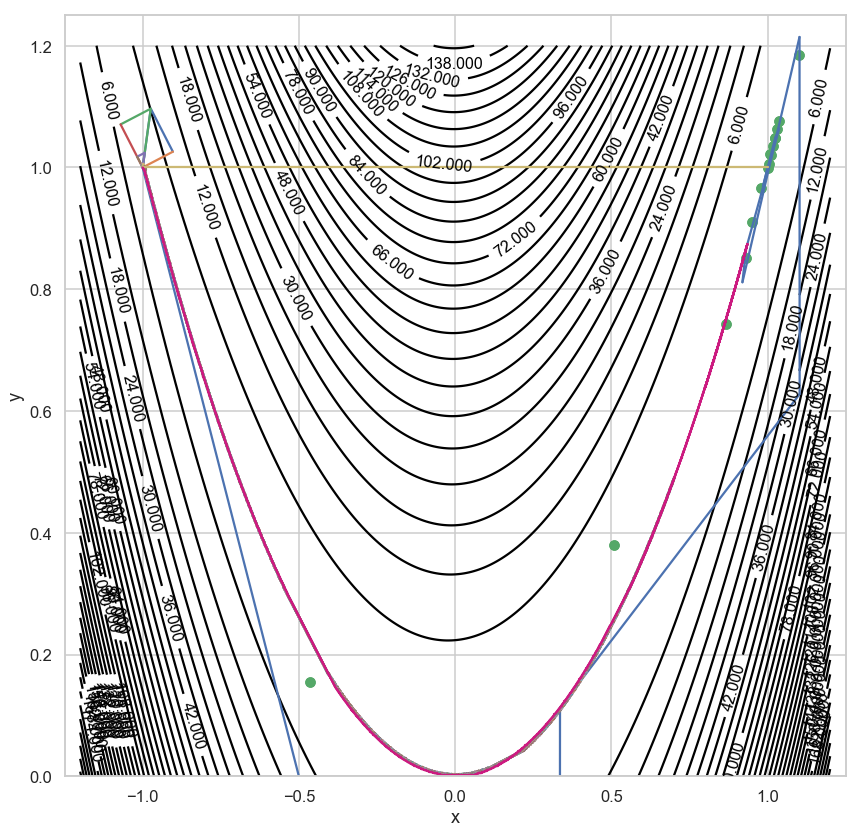

In [64]:
%%time
from scipy.optimize import minimize
import time
import seaborn as sns
sns.set_context("talk")


f5 = lambda x1,x2: 100*((x1**2-x2)**2)+(x1-1)**2


a,b = -1,1
methods = [
    ('М. наискорейшего спуска',fast_descent,[a,b],True),
    #('М. сопряженных градиентов',sopr_grad,[a,b],False),
    ('М. Ньютона',newton,[a,b],True),
    ('М. правильного симплекса',right_simplex,[a,b],True),
    ('М. циклического спуска',circle_descent,[a,b],True),
    ('М. Хука-Дживса',hook_djivs,[a,b],True),
    ('М. случайного поиска',random_search,[a,b],True),
]


#eps = [10**-i for i in range(1,7)]
eps = [10**-3]

size_subplots = [3,1]

current_f = f5

error_methods = []

x_test = [1,1]
plt.figure()
plot_countor2(f5,-1.2,1.2,0,1.2)

for (label,method,bound,verbose) in methods:
 
    print(label,end=' ')
    n_f = []
    it = []
    times = []
    
    flag = False
    for ei in eps:
        print(ei,end=' ')
        arg = [method,current_f]
        if bound != None:
           arg.append(bound) 

        start = time.clock()
        x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei,verbose=verbose)
        stop = time.clock()
        
        if True:#euklid(np.array(x_test)-np.array(x)) < ei:
            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)
        else:
            
            print('-------',x_test,x,euklid(np.array(x_test)-np.array(x)))
            flag = True
            error_methods.append(label)
            break
            

    print(end='\n')

plt.xlim([-1.25,1.25])
plt.ylim([0,1.25])
print()

М. правильного симплекса 0.001 

Wall time: 33.8 s


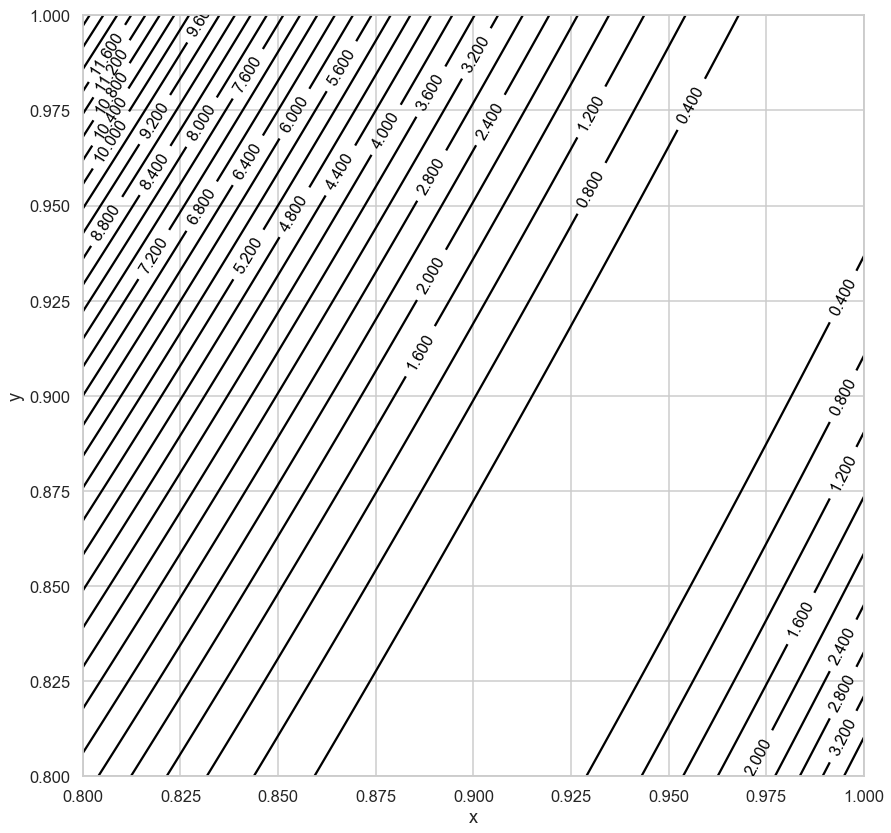

In [97]:
%%time
from scipy.optimize import minimize
import time
import seaborn as sns
sns.set_context("talk")


f5 = lambda x1,x2: 100*((x1**2-x2)**2)+(x1-1)**2


a,b = -1,1
methods = [
    #('М. наискорейшего спуска',fast_descent,[a,b],True),
    #('М. сопряженных градиентов',sopr_grad,[a,b],False),
    #('М. Ньютона',newton,[a,b],True),
    ('М. правильного симплекса',right_simplex,[a,b],True),
    #('М. циклического спуска',circle_descent,[a,b],True),
    #('М. Хука-Дживса',hook_djivs,[a,b],True),
    #('М. случайного поиска',random_search,[a,b],True),
]


#eps = [10**-i for i in range(1,7)]
eps = [10**-3]

size_subplots = [3,1]

current_f = f5

error_methods = []

x_test = [1,1]
plt.figure()
a,b=0.8,1
plot_countor2(f5,a,b,a,b)

for (label,method,bound,verbose) in methods:
 
    print(label,end=' ')
    n_f = []
    it = []
    times = []
    
    flag = False
    for ei in eps:
        print(ei,end=' ')
        arg = [method,current_f]
        if bound != None:
           arg.append(bound) 

        start = time.clock()
        x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei,verbose=verbose)
        stop = time.clock()
        
        if True:#euklid(np.array(x_test)-np.array(x)) < ei:
            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)
        else:
            
            print('-------',x_test,x,euklid(np.array(x_test)-np.array(x)))
            flag = True
            error_methods.append(label)
            break
            

    print(end='\n')

plt.xlim([a,b])
plt.ylim([a,b])
print()

М. правильного симплекса 0.001 

Wall time: 32.5 s


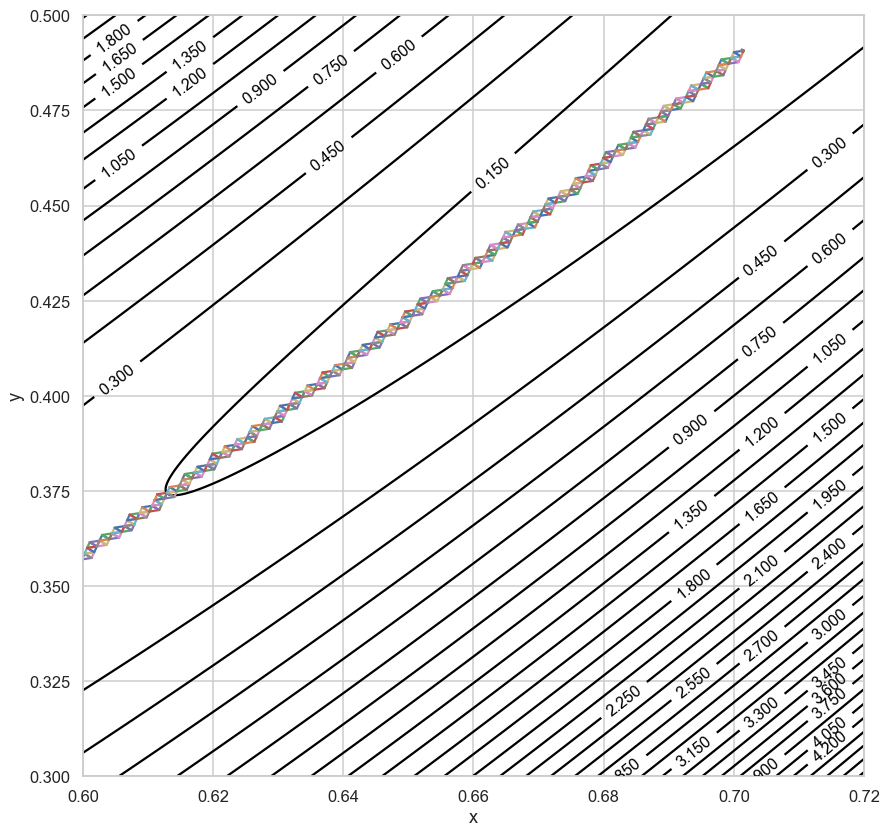

In [100]:
%%time
from scipy.optimize import minimize
import time
import seaborn as sns
sns.set_context("talk")


f5 = lambda x1,x2: 100*((x1**2-x2)**2)+(x1-1)**2


a,b = -1,1
methods = [
    #('М. наискорейшего спуска',fast_descent,[a,b],True),
    #('М. сопряженных градиентов',sopr_grad,[a,b],False),
    #('М. Ньютона',newton,[a,b],True),
    ('М. правильного симплекса',right_simplex,[a,b],True),
    #('М. циклического спуска',circle_descent,[a,b],True),
    #('М. Хука-Дживса',hook_djivs,[a,b],True),
    #('М. случайного поиска',random_search,[a,b],True),
]


#eps = [10**-i for i in range(1,7)]
eps = [10**-3]

size_subplots = [3,1]

current_f = f5

error_methods = []

x_test = [1,1]
plt.figure()
ax,bx,ay,by=0.6,0.72,0.3,0.5
plot_countor2(f5,ax,bx,ay,by)

for (label,method,bound,verbose) in methods:
 
    print(label,end=' ')
    n_f = []
    it = []
    times = []
    
    flag = False
    for ei in eps:
        print(ei,end=' ')
        arg = [method,current_f]
        if bound != None:
            arg.append(bound) 

        start = time.clock()
        x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei,verbose=verbose)
        stop = time.clock()
        
        if True:#euklid(np.array(x_test)-np.array(x)) < ei:
            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)
        else:
            
            print('-------',x_test,x,euklid(np.array(x_test)-np.array(x)))
            flag = True
            error_methods.append(label)
            break
            

    print(end='\n')

plt.xlim([ax,bx])
plt.ylim([ay,by])
print()

### Задание №6

М. наискорейшего спуска 0.1 [0 0]
0.01 [0 0]
0.001 [0 0]
0.0001 [0 0]
1e-05 [0 0]

М. сопряженных градиентов 0.1 [0, 0]
0.01 [0, 0]
0.001 [0, 0]
0.0001 [0, 0]
1e-05 [0, 0]

М. Ньютона 0.1 [0, 0]
0.01 [0, 0]
0.001 [0, 0]
0.0001 [0, 0]
1e-05 [0, 0]

М. наискорейшего спуска 0.1 [-5.03050258e+00  2.80020000e-03]
0.01 [-3.46105614 -3.2810072 ]
0.001 [-2.60880136  2.99706169]
0.0001 [-3.75491608 -3.21023268]
1e-05 [-3.7482341  -3.18148274]

М. сопряженных градиентов 0.1 [ 3.58379285 -1.84777428]
0.01 [ 3.58441632 -1.84783171]
0.001 [ 3.58442762 -1.84810883]
0.0001 [ 3.58442828 -1.84812504]
1e-05 [ 3.58442822 -1.84812606]

М. Ньютона 0.1 [-3.07311801 -0.08132482]
0.01 [-3.07311801 -0.08132482]
0.001 [-3.07302559 -0.0813531 ]
0.0001 [-3.07302559 -0.0813531 ]
1e-05 [-3.07302559 -0.0813531 ]

Wall time: 335 ms


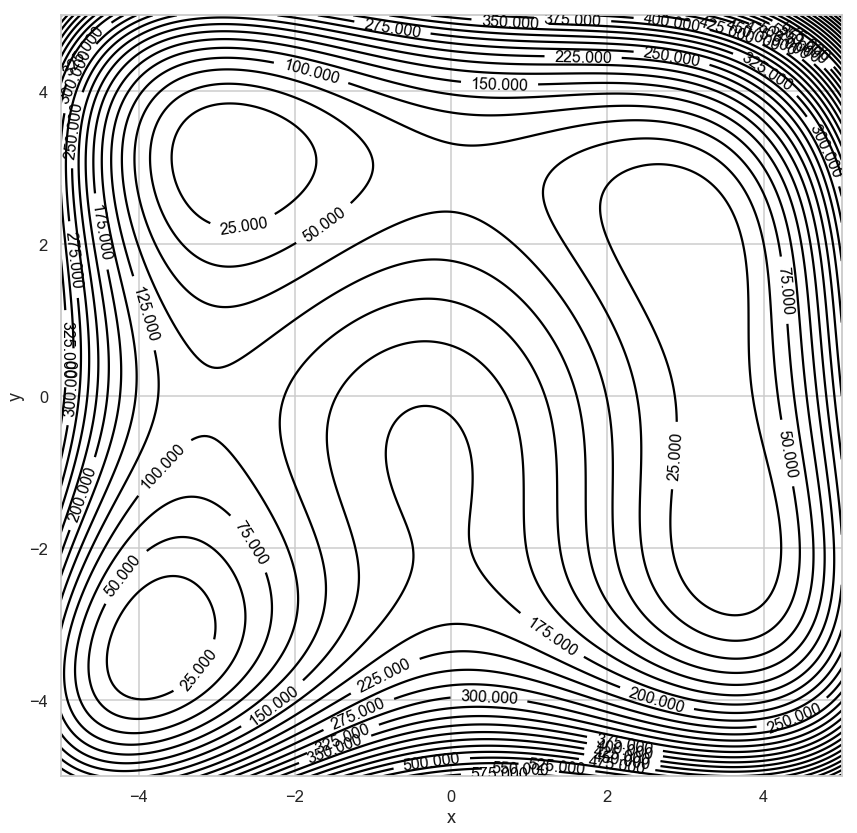

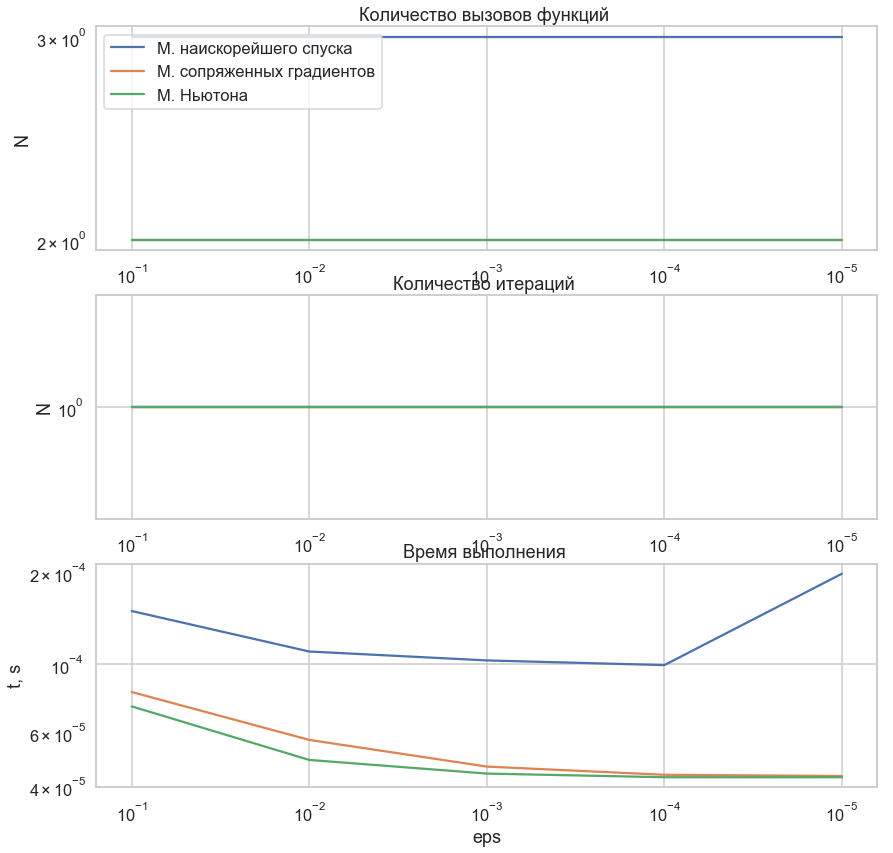

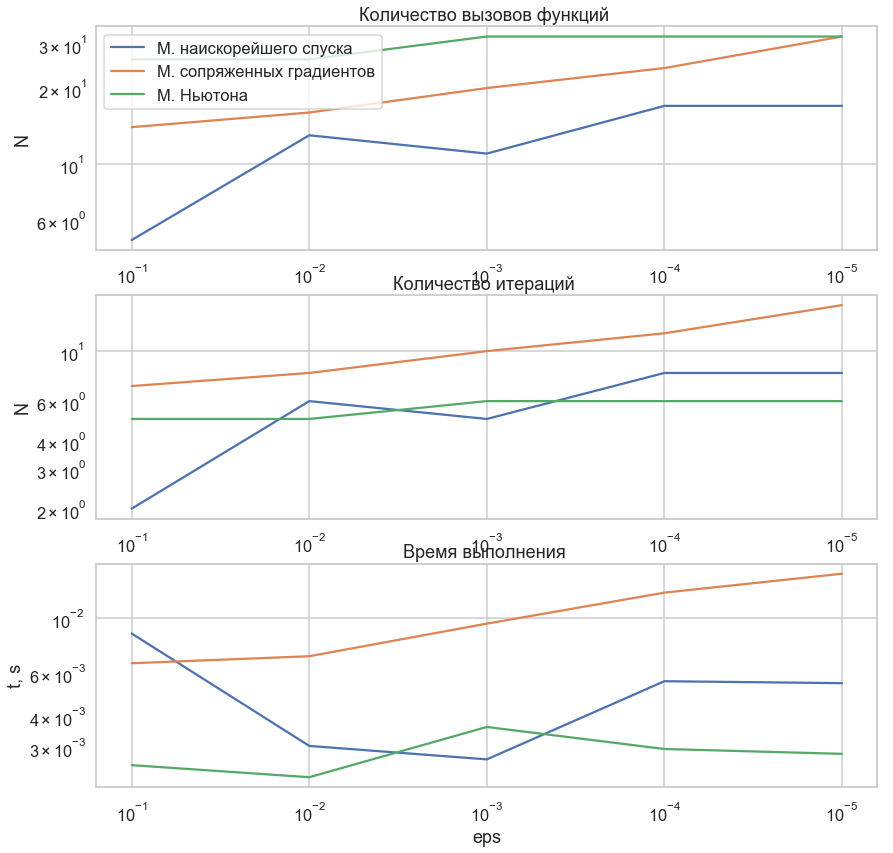

In [26]:
%%time
from scipy.optimize import minimize
import time
sns.set_context("talk")


f6 = lambda x1,x2: (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

plot_countor2(f6,-5,5,-5,5)

bounds = [(0,0),(-5.0001,0)]
for a,b in bounds:
    methods = [
        ('М. наискорейшего спуска',fast_descent,[a,b],True),
        ('М. сопряженных градиентов',sopr_grad,[a,b],True),
        ('М. Ньютона',newton,[a,b],True),
    ]


    eps = [10**-i for i in range(1,6)]
    #eps = [10**-3,10**-5]

    size_subplots = [3,1]


    plt.figure()
    current_f = f6

    error_methods = []

    x_test = [1,1]
    for (label,method,bound,verbose) in methods:
        print(label,end=' ')
        n_f = []
        it = []
        times = []
        for ei in eps:
            print(ei,end=' ')
            arg = [method,current_f]
            if bound != None:
               arg.append(bound) 

            start = time.clock()
            x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei,verbose=verbose)
            stop = time.clock()
            
            print(x)

            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)

        print(end='\n')

        plt.subplot(size_subplots[0],size_subplots[1],1)
        plt.plot(eps,n_f,label=label)
        plt.xscale('log')

        plt.subplot(size_subplots[0],size_subplots[1],2)
        plt.plot(eps,it,label=label)
        plt.xscale('log')

        plt.subplot(size_subplots[0],size_subplots[1],3)
        plt.plot(eps,times,label=label)
        plt.xscale('log')

    plt.subplot(size_subplots[0],size_subplots[1],1)
    plt.title('Количество вызовов функций ')
    plt.legend(loc='upper left')
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')


    plt.subplot(size_subplots[0],size_subplots[1],2)
    plt.title('Количество итераций ')
    plt.gca().invert_xaxis()
    plt.ylabel('N')
    plt.yscale('log')

    plt.subplot(size_subplots[0],size_subplots[1],3)
    plt.title('Время выполнения ')
    plt.gca().invert_xaxis()
    plt.xlabel('eps')
    plt.ylabel('t, s')
    plt.yscale('log')


М. наискорейшего спуска 0.1 [0 0]
0.01 [0 0]
0.001 [0 0]
0.0001 [0 0]
1e-05 [0 0]

М. сопряженных градиентов 0.1 [0, 0]
0.01 [0, 0]
0.001 [0, 0]
0.0001 [0, 0]
1e-05 [0, 0]

М. Ньютона 0.1 [0, 0]
0.01 [0, 0]
0.001 [0, 0]
0.0001 [0, 0]
1e-05 [0, 0]

М. наискорейшего спуска 0.1 [-5.03050258e+00  2.80020000e-03]
0.01 [-3.46105614 -3.2810072 ]
0.001 [-2.60880136  2.99706169]
0.0001 [-3.75491608 -3.21023268]

No handles with labels found to put in legend.



1e-05 [-3.7482341  -3.18148274]

М. сопряженных градиентов 0.1 [ 3.58379285 -1.84777428]
0.01 [ 3.58441632 -1.84783171]
0.001 [ 3.58442762 -1.84810883]
0.0001 [ 3.58442828 -1.84812504]
1e-05 [ 3.58442822 -1.84812606]

М. Ньютона 0.1 [-3.07311801 -0.08132482]
0.01 [-3.07311801 -0.08132482]
0.001 [-3.07302559 -0.0813531 ]
0.0001 [-3.07302559 -0.0813531 ]
1e-05 [-3.07302559 -0.0813531 ]

Wall time: 438 ms


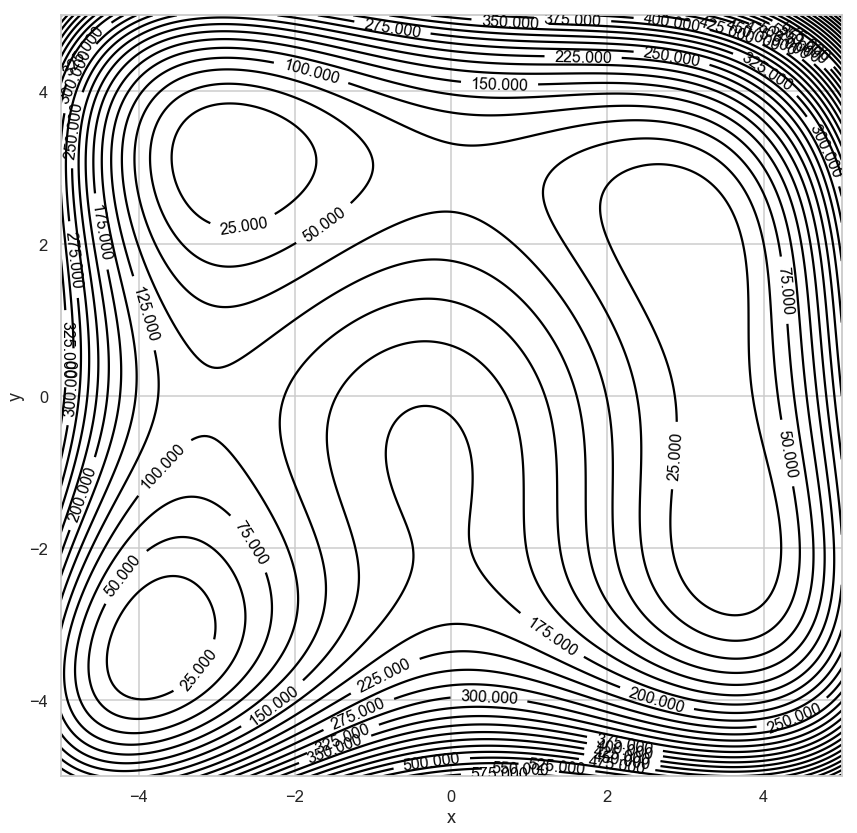

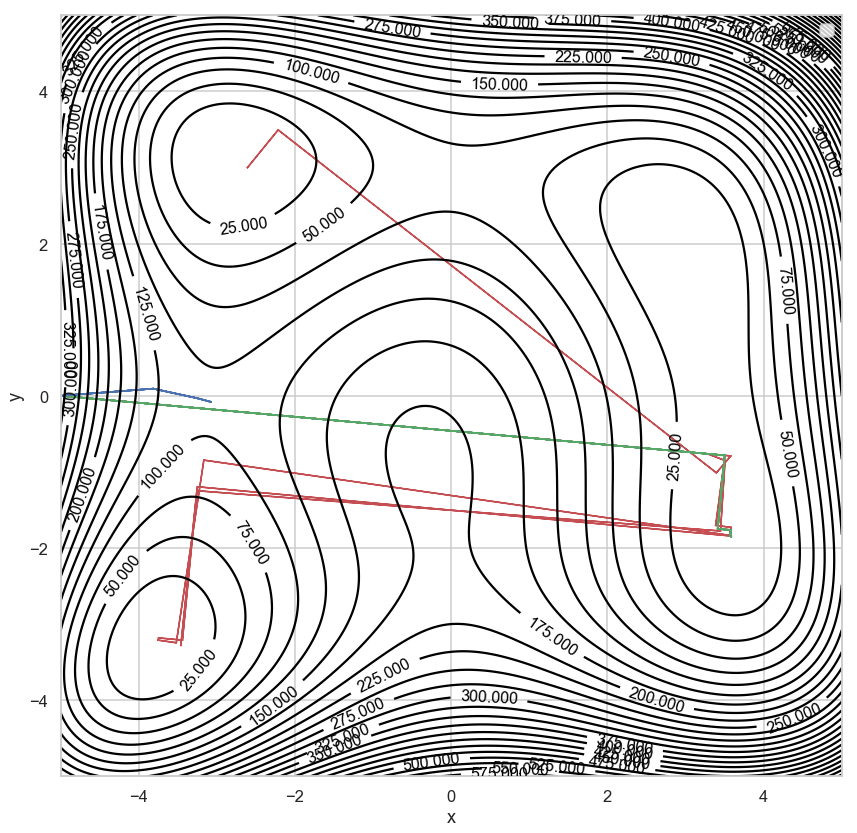

In [48]:
%%time
from scipy.optimize import minimize
import time
sns.set_context("talk")


f6 = lambda x1,x2: (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2


bounds = [(0,0),(-5.0001,0)]
for a,b in bounds:
    methods = [
        ('М. наискорейшего спуска',fast_descent,[a,b],True),
        ('М. сопряженных градиентов',sopr_grad,[a,b],True),
        ('М. Ньютона',newton,[a,b],True),
    ]


    eps = [10**-i for i in range(1,6)]
    #eps = [10**-3,10**-5]

    size_subplots = [3,1]


    plt.figure()
    
    plot_countor2(f6,-5,5,-5,5)
    current_f = f6

    error_methods = []

    x_test = [1,1]
    for (label,method,bound,verbose) in methods:
        print(label,end=' ')
        n_f = []
        it = []
        times = []
        for ei in eps:
            print(ei,end=' ')
            arg = [method,current_f]
            if bound != None:
               arg.append(bound) 

            start = time.clock()
            x,fx,it_s,n_s = test_func_multi2(*arg,eps=ei,verbose=verbose)
            stop = time.clock()
            
            print(x)

            n_f.append(n_s)
            it.append(it_s)
            times.append(stop-start)

        print(end='\n')

      

### Задание №7

In [28]:
def BFGS(f,x0,eps=10**-3,norm=euklid):
    n = len(x0)
    x = copy(x0)
    
    
    g,n_s = gradient(f,x)
    n_f = n_s
    it = 1
    
    hs = np.eye(n)
    n_f += n_s
    
    x_old = copy(x0)
    g_old = copy(g)
    
    print(it,'----')
    print(hs)
    temp = hesse(f,x)[0]
    print(temp)
    
    x_new = x_old - np.linalg.inv(hs).dot(g)
    
    while not norm(g_old) < eps:
        
        g_new,n_s = gradient(f,x_new)
        n_f += n_s
        
        q = (g_new - g_old).reshape(n,1)
        g_old = g_new
        
        s = (x_new - x_old).reshape(n,1)
        x_old = x_new
        
        a = q.dot(q.T)
        b = q.T.dot(s)
        c = hs.T.dot(s).dot(s.T).dot(hs)
        d = s.T.dot(hs).dot(s)
        hs = hs + a/b-c/d
        n_f += n_s
        
        x_new = x_old - np.linalg.inv(hs).dot(g_old)
        
        it += 1
        print(it,'----')
        print(hs)
        temp = hesse(f,x_new)[0]
        print(temp)
        
        
    return x_new,f(*x_new),it,n_f


test_func_multi(BFGS,[10,10])  

1 ----
[[1. 0.]
 [0. 1.]]
[[98000000.        0.]
 [       0. 32000000.]]
2 ----
[[ 301.71171539 -296.05131913]
 [-296.05131913  290.91460158]]
[[-968.93310547    0.        ]
 [   0.           -7.62939453]]
3 ----
[[ 257.4366873  -267.01316978]
 [-267.01316978  277.58235789]]
[[-15625.            0.      ]
 [     0.          244.140625]]
4 ----
[[ 292.0577272  -289.70929651]
 [-289.70929651  291.34864453]]
[[ 301.99997127 -300.01997948]
 [-300.01997948  301.95899308]]
5 ----
[[ 292.75609498 -290.33141536]
 [-290.33141536  291.88721309]]
[[ 302.00000401 -300.00000334]
 [-300.00000334  302.00000401]]
6 ----
[[ 301.99156142 -299.99426507]
 [-299.99426507  301.99610247]]
[[ 302.00000083 -300.0000147 ]
 [-300.0000147   301.99988396]]
7 ----
[[ 301.98771994 -299.99088497]
 [-299.99088497  301.99323425]]
[[ 302.00002857 -300.00001334]
 [-300.00001334  301.99999946]]
8 ----
[[ 301.99984081 -299.99982346]
 [-299.99982346  301.9997853 ]]
[[ 301.99991215 -299.99995513]
 [-299.99995513  301.9999121

(array([-32.94518272, -33.05481728]), -2131.8089700996397, 8, 32)